# Projet CSAA - Classification du rythme cardiaque issu d'ECG


Ce jeu de données est composé d'une collections de signaux de battements cardiaques provenant d'un jeu de données célèbres dans le domaine de la classification des battements cardiaques, le jeu de données sur l'arythmie du MIT-BIH.

Les signaux correspondent à des formes d'électrocardiogramme (ECG) de battements cardiaques pour le cas normal et les cas affectés par différentes arythmies et infarctus du myocarde. Ces signaux sont prétraités et segmentés, chaque segment correspondant à un battement cardiaque.

<img src="https://github.com/LeopoldLopez/DAC2/blob/main/DataECG.png?raw=1" width="800" height="600">

On distingue 5 battements cardiaques différents : Battements normaux', 'Battements inconnus', 'Battements ectopiques ventriculaires', 'Battements ectopiques supraventriculaires' et 'Battements de fusion'.

De ces signaux, on extrait des caractéristiques par la librairie TSFEL - *Time Series Features Extraction Library* (https://tsfel.readthedocs.io/en/latest/index.html)

Les 156 caractéristiques extraites sont divisées selon les domaines :
- temporel avec 31 caractéristiques comme l'entropie, Max, Min, Absolute Energy ...
- statistique avec 14 caractéristiques comme écart moyen absolu, écart médian, variance, Kurtosis...
- spectral  avec 111 caractéristiques comme les coefficients FFT par bande de fréquence, ondelettes...

Lien vers le papier expliquant TSFEL : https://www.sciencedirect.com/science/article/pii/S2352711020300017

In [95]:
# Librairies utiles
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Chargement des données d'apprentissage et de test

In [96]:
# Chargement des données brutes
DataECGFull=np.load('./DataECG.npy')
print('Taille du dataset ECG:', DataECGFull.shape)

# Après extraction des features
# Chargement des données d'apprentissage
DataFeature=np.load('./DataFeature.npy')
Label=np.load('./Label.npy')
print('Taille du dataset après extraction de features :', DataFeature.shape, Label.shape)


# Séparation en ensemble d'apprentissage et de test
from sklearn.model_selection import train_test_split

# la dernière colonne sont des labels
DataECGFull = DataECGFull[:,:-1]
DataFeature = DataFeature[:,:-1]

DataECGApp, DataECGTest, Label_train, Label_test = train_test_split(DataECGFull, Label, test_size=0.2, random_state=42)
DataFeatureApp, DataFeatureTest, LabelF_train, LabelF_test = train_test_split(DataFeature, Label, test_size=0.2, random_state=42)

print('Taille de la base d apprentissage ECG :', DataECGApp.shape, 'Taille du dataset de test ECG :', DataECGTest.shape)
print('Taille de la base d apprentissage Features :', DataFeatureApp.shape, 'Taille du dataset de test Features :', DataFeatureTest.shape)


Taille du dataset ECG: (5000, 188)
Taille du dataset après extraction de features : (5000, 156) (5000,)
Taille de la base d apprentissage ECG : (4000, 187) Taille du dataset de test ECG : (1000, 187)
Taille de la base d apprentissage Features : (4000, 155) Taille du dataset de test Features : (1000, 155)


# Chargement des variables issues *TSFEL*

In [97]:
ListeVariablesStat=np.load('./ListeVariableStat.npy',allow_pickle=True)
print('Nombre de variables statistiques :',ListeVariablesStat.shape)
#print('Liste Variables Statistiques :', ListeVariablesStat)

ListeVariablesTemps=np.load('./ListeVariableTemps.npy',allow_pickle=True)
print('Nombre de variables temporelles :',ListeVariablesTemps.shape)
#print('Liste Variables Temporelles :',ListeVariablesTemps)

ListeVariablesSpectral=np.load('./ListeVariableSpectral.npy',allow_pickle=True)
print('Nombre de variables spectrales :',ListeVariablesSpectral.shape)
#print('Liste Variables Spectrales :',ListeVariablesSpectral)

Nombre de variables statistiques : (31,)
Nombre de variables temporelles : (14,)
Nombre de variables spectrales : (111,)


### Fonctions pour réaliser une table de correspondance entre le label des approches non supervisées et le label réel

In [98]:
def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.

# Initialisation
  reference_labels = np.zeros(len(np.unique(cluster_labels)), dtype=int)
# Loop pour chaque label  
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

def correspondance(y_pred_kmeans,y_train):
  # Correspondance entre la partition et les classes de la vérité terrain
  reference_labels = retrieve_info(y_pred_kmeans,y_train)
  number_labels = np.zeros(len(y_pred_kmeans))
  for i in range(len(y_pred_kmeans)):
    number_labels[i] = reference_labels[y_pred_kmeans[i]]
  return number_labels


In [99]:
# Consts

DATASET = DataFeature
DATASET_APP = DataFeatureApp
DATASET_TEST = DataFeatureTest
# DATASET_TEST = DataFeatureTest[:100,:]
LABEL = Label
LABEL_APP = LabelF_train
LABEL_TEST = LabelF_test
# LABEL_TEST = LabelF_test[:100]

# Partie I : Implémentation de l'algorithme de programmation dynamique (DTW)

1. Ecrivez une fonction en python DTW qui implémente le calcul et l'affichage de la matrice des coûts définie en TD.



In [100]:
from math import sqrt
import numpy as np

In [101]:
def DTW(A, B, distance, weights):
    w0,w1,w2 = weights
    n,m = len(A),len(B)
    g = np.zeros((n+1,m+1))
    d = np.array([[distance(A[i], B[j]) for j in range(m)] for i in range(n)])

    for j in range(1,m+1):
      g[0,j] = np.inf
    for i in range(1,n+1):
      g[i, 0] = np.inf
      for j in range(1,m+1):
        # print(i,j)
        # print(d.shape)
        g[i,j] = min(
            g[i-1, j] + w0*d[i-1,j-1],
            g[i-1,j-1] + w1*d[i-1,j-1],
            g[i, j-1] + w2*d[i-1,j-1],
        )

    s = g[n, m]/(n+m)

    return s,g

# Exemple du CTD
# DTW([-1, 0, 1, 2], [2, 1, 1, -1, 0], lambda a, b: sqrt((a-b)**2))
# Avec w0 = w1 = w2 = 1 on a bien le résultat attendu


## Système de reconnaissance de battements cardiaques par DTW

**Système de reconnaissance :**
Pour chaque profil temporel test :

a) Calculer pour chaque classe, le score de la DTW entre le profil temporel test et les profils temporels de la classe

b) Déterminer la classe d'appartenance par minimum du score sur toutes les classes


In [102]:
# Moyenne des classes

def average(l):
  t = zip(*l)
  return [sum(g)/len(g) for g in t]

nb_class = int(max(LABEL_APP))+1
class_profiles = [[] for i in range(nb_class)]
for i,x in enumerate(DATASET_APP):
  class_profiles[int(LABEL_APP[i])].append(x)
for i, x in enumerate(class_profiles):
  class_profiles[i] = average(x)

In [103]:
def distance(ai, bj):
  return sqrt((ai - bj)**2)

scores = np.zeros((len(DATASET_TEST), nb_class))
for i,l in enumerate(DATASET_TEST):
  for j,cp in enumerate(class_profiles):
    s,_ = DTW(l, cp, distance, (1,2,1))
    scores[i, j] = s

In [104]:
new_label_test = np.array(list(map((lambda l: np.argmin(l)), scores)))
PartitionDTW = np.array([LABEL_TEST, new_label_test])

**Evaluation :** A partir de la partition de l'ensemble test obtenue après la DTW, calculer la matrice de confusion qui recense le nombre de données bien classés et mal classés.

In [105]:
# Evaluation des résultats par matrices de confusion
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


Matrice de confusion par DTW
Accuracy sur base de test : 37.4%


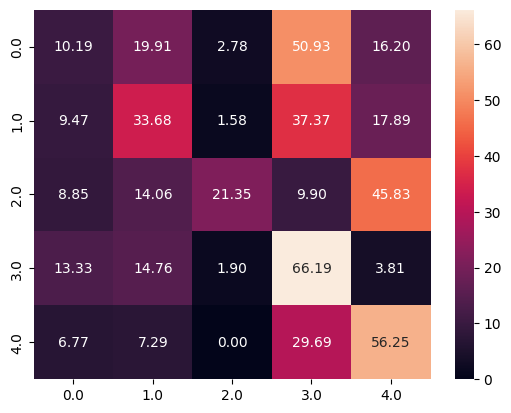

In [106]:
print('Matrice de confusion par DTW')
cm=confusion_matrix(PartitionDTW[0],PartitionDTW[1])
cm = cm / cm.sum(axis=1, keepdims=True) * 100
sns.heatmap(data=cm,fmt='.2f',xticklabels=np.unique(LABEL_TEST),yticklabels=np.unique(LABEL_TEST),annot=True)

# score de performance
print(f'Accuracy sur base de test : {accuracy_score(PartitionDTW[0],PartitionDTW[1])*100}%')

# Partie II : Classification des battements cardiaques sur les features sans prétraitement

Réaliser une classification des battements cardiaques par une méthode d'apprentissage supervisé et une méthode d'apprentissage non supervisé de votre choix en utilisant la librairie *scikit-learn*.

Pour chaque résultat obtenu, calculer la matrice de confusion et interpréter les résultats.


### Analyse de la répartition des classes

On s'intéresse à la répartition des classes pour nous permettre de mieux choisir les méthodes de classification (ex : clusters sphériques --> k-means).
Pour se faire on va réaliser une analyse en composantes principales (ACP) pour visualiser la répartition des classes (de plus, le code pourra être réutilisé pour la partie III).

/tmp/ipykernel_161306/749732936.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], [], c=cmap(i), label=label)


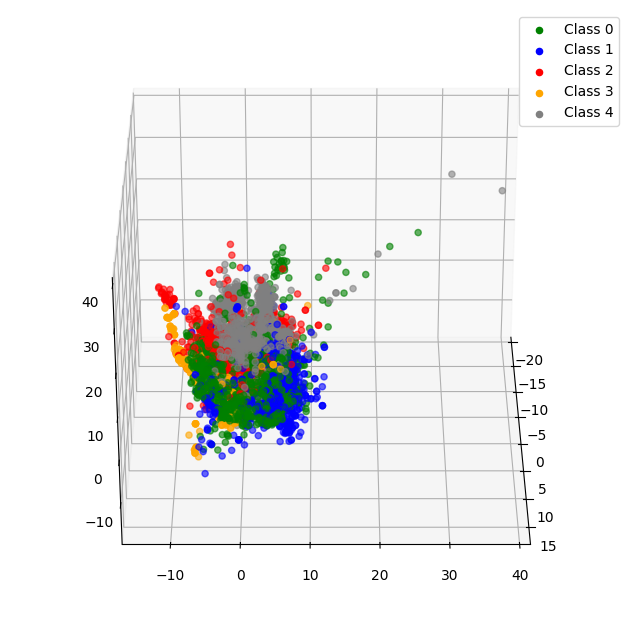

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [107]:
from matplotlib.colors import BoundaryNorm, ListedColormap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.animation as animation
import os

# Centrer et réduire les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(DATASET)

# Réduire les données en 2 dimensions
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Pour la légende
cmap = ListedColormap(['green', 'blue', 'red', 'orange', 'grey'])
norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], cmap.N)

# 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                     c=LABEL, cmap=cmap, norm=norm, alpha=0.6)

class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
for i, label in enumerate(class_labels):
    ax.scatter([], [], [], c=cmap(i), label=label)
ax.legend(loc='upper right')

# Animation
angles = np.linspace(0, 360, 36)  # 36 frames for a smooth rotation
for angle in angles:
    ax.view_init(elev=30, azim=angle) # type: ignore
    plt.draw()
    plt.pause(0.1)  # Pause to control the speed of rotation

def update(frame):
    ax.view_init(elev=30, azim=frame) # type: ignore
    return ax,

ani = animation.FuncAnimation(fig, update, frames=angles, interval=50, blit=False)

os.makedirs('results', exist_ok=True)
ani.save('results/3D_PCA_rotation_fast.gif', writer='pillow', fps=20)

plt.show()


In [108]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def cma(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True) * 100
    accuracy = accuracy_score(y_true, y_pred)
    return cm, accuracy

def cm_print(y_true, y_pred):
    cm, accuracy = cma(y_true, y_pred)
    sns.heatmap(data=cm,fmt='.2f',xticklabels=np.unique(y_true),yticklabels=np.unique(y_true),annot=True)
    print(f'Accuracy sur base de test : {accuracy*100}%')
    print("Matrice de confusion :")    

## Méthodes supervisées  :
indiquer quelles sont les 2 méthodes supervisées de votre choix et calculer la matrice de confusion associée.

### Random Forest  

Best number of estimators : 195
Accuracy sur base de test : 92.5%
Matrice de confusion :


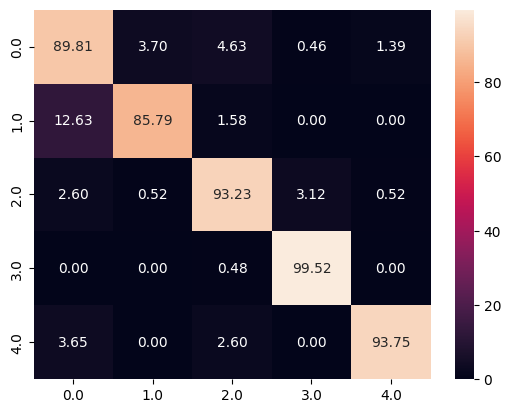

In [109]:
from sklearn.ensemble import RandomForestClassifier

best_nb_estimators, best_labels, best_accuracy = 0, None, 0

for nb_estimators in np.arange(5, 200, 5):
    clf = RandomForestClassifier(
        n_estimators=nb_estimators,
        random_state=42
    )
    clf.fit(DATASET_APP, LABEL_APP)
    y_pred = clf.predict(DATASET_TEST)
    accuracy = accuracy_score(LABEL_TEST, y_pred)
    if accuracy > best_accuracy:
        best_labels = y_pred
        best_nb_estimators = nb_estimators

print(f'Best number of estimators : {best_nb_estimators}')
cm_print(LABEL_TEST, best_labels)

### SVM

Best C : 1000, Best gamma : auto
Accuracy sur base de test : 92.2%
Matrice de confusion :


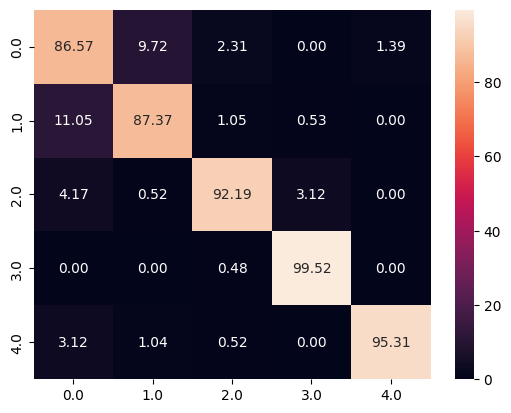

In [110]:
from sklearn.svm import SVC


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(DATASET_APP)
X_test_scaled = scaler.transform(DATASET_TEST)

# kernel rbf parce que les données ne semblent pas linéairement séparables
best_c, best_gamma, best_labels, best_accuracy = 0, 0, None, 0
Cs = [0.01, 0.1, 1, 10, 100, 1000]
gammas = ['scale', 'auto']
for c in Cs:
    for gamma in gammas:
        svm = SVC(kernel='rbf', C=c, gamma=gamma, random_state=42) # type: ignore
        svm.fit(X_train_scaled, LABEL_APP)
        y_pred = svm.predict(X_test_scaled)
        accuracy = accuracy_score(LABEL_TEST, y_pred)
        if accuracy > best_accuracy:
            best_labels = y_pred
            best_c = c
            best_gamma = gamma

print(f'Best C : {best_c}, Best gamma : {best_gamma}')
cm_print(LABEL_TEST, best_labels)

## Méthodes non supervisées

Indiquer quelles sont les 2 méthodes non supervisées de votre choix et calculer la matrice de confusion associée.

### K-means

Accuracy sur base de test : 40.42%
Matrice de confusion :


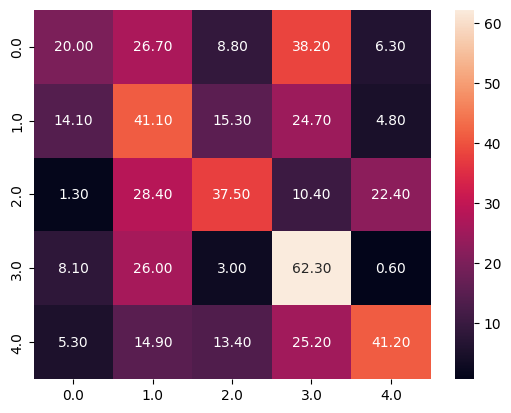

In [111]:
from sklearn.cluster import KMeans
        
kmeans = KMeans(n_clusters=5, random_state=42).fit_predict(DATASET)

cm_print(LABEL, correspondance(kmeans.astype(int), LABEL.astype(int)))

### AgglomerativeClustering

best metric: euclidean, best linkage: ward
Accuracy sur base de test : 50.480000000000004%
Matrice de confusion :


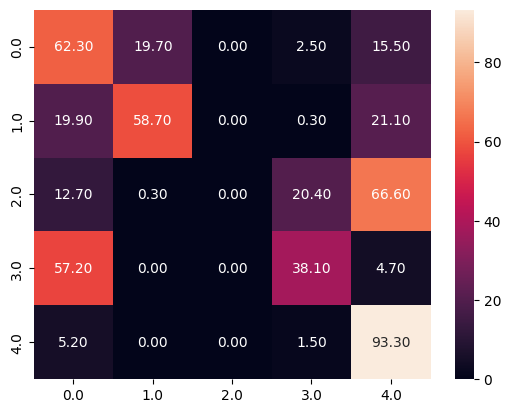

In [112]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

scaler = StandardScaler()
X_scaled = scaler.fit_transform(DATASET)

metrics = ['euclidean', 'manhattan', 'cosine']
linkages = ['ward', 'complete', 'average', 'single']

best_labels, best_accuracy, best_metric, best_linkage = None, 0, None, None
for metric in metrics:
    for linkage in linkages:
        if linkage == 'ward' and metric != 'euclidean':
            continue
        agglo_model = AgglomerativeClustering(
            n_clusters=5,
            metric=metric,
            linkage=linkage # type: ignore
        )
        labels = agglo_model.fit_predict(X_scaled)
        accuracy = accuracy_score(LABEL, correspondance(labels.astype(int), LABEL.astype(int)))
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_labels = labels
            best_metric = metric
            best_linkage = linkage

print(f'best metric: {best_metric}, best linkage: {best_linkage}')
cm_print(LABEL, correspondance(best_labels.astype(int), LABEL.astype(int))) # type: ignore

# Partie III : classification des battements cardiaques sur les features avec prétraitement par ACP

## Méthode supervisée avec réduction de dimension par ACP sur l'ensemble d'apprentissage
Réaliser une ACP sur l'ensemble d'apprentissage pour réduire la dimension, visualiser les données
puis projeter les données de l'ensemble de test dans la base de l'ACP.

Indiquer quelles sont les 2 méthodes supervisées de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

/tmp/ipykernel_161306/2389205429.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=cmap(i), label=label)


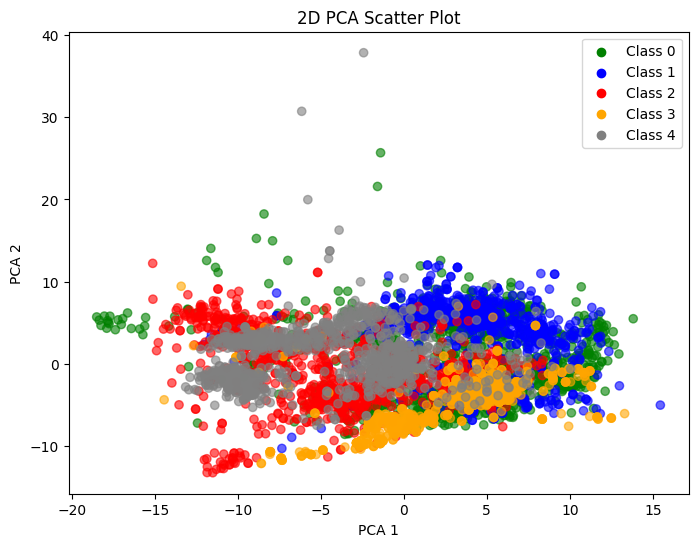

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(DATASET)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

cmap = ListedColormap(['green', 'blue', 'red', 'orange', 'grey'])
norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], cmap.N)

fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1],
                     c=LABEL, cmap=cmap, norm=norm, alpha=0.6)

class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
for i, label in enumerate(class_labels):
    ax.scatter([], [], c=cmap(i), label=label)
ax.legend(loc='best')

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_title('2D PCA Scatter Plot')
plt.show()


In [119]:
DATASET = X_pca
DATASET_APP, DATASET_TEST, LABEL_APP, LABEL_TEST = train_test_split(DATASET, LABEL, test_size=0.2, random_state=42)

### Random Forest

Best number of estimators : 195
Accuracy sur base de test : 70.5%
Matrice de confusion :


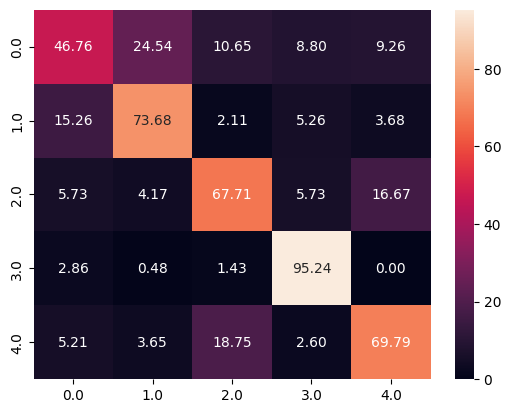

In [120]:
from sklearn.ensemble import RandomForestClassifier

best_nb_estimators, best_labels, best_accuracy = 0, None, 0

for nb_estimators in np.arange(5, 200, 5):
    clf = RandomForestClassifier(
        n_estimators=nb_estimators,
        random_state=42
    )
    clf.fit(DATASET_APP, LABEL_APP)
    y_pred = clf.predict(DATASET_TEST)
    accuracy = accuracy_score(LABEL_TEST, y_pred)
    if accuracy > best_accuracy:
        best_labels = y_pred
        best_nb_estimators = nb_estimators

print(f'Best number of estimators : {best_nb_estimators}')
cm_print(LABEL_TEST, best_labels)


### SVM

Best C : 1000, Best gamma : auto
Accuracy sur base de test : 66.8%
Matrice de confusion :


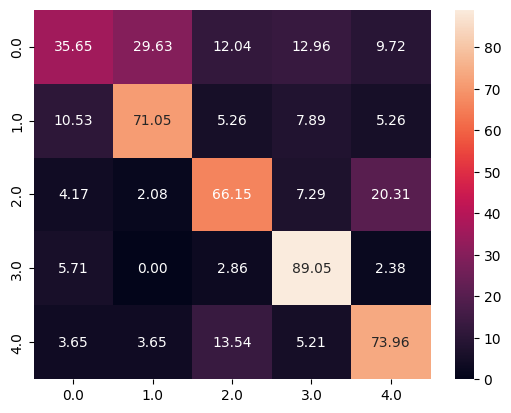

In [121]:
from sklearn.svm import SVC


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(DATASET_APP)
X_test_scaled = scaler.transform(DATASET_TEST)

# kernel rbf parce que les données ne semblent pas linéairement séparables
best_c, best_gamma, best_labels, best_accuracy = 0, 0, None, 0
Cs = [0.01, 0.1, 1, 10, 100, 1000]
gammas = ['scale', 'auto']
for c in Cs:
    for gamma in gammas:
        svm = SVC(kernel='rbf', C=c, gamma=gamma, random_state=42) # type: ignore
        svm.fit(X_train_scaled, LABEL_APP)
        y_pred = svm.predict(X_test_scaled)
        accuracy = accuracy_score(LABEL_TEST, y_pred)
        if accuracy > best_accuracy:
            best_labels = y_pred
            best_c = c
            best_gamma = gamma

print(f'Best C : {best_c}, Best gamma : {best_gamma}')
cm_print(LABEL_TEST, best_labels)

## Méthode non supervisée avec réduction de dimension par ACP sur l'ensemble des données

Réaliser une ACP sur l'ensemble des données et indiquer quelles sont les méthodes non supervisées de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

### K-means

Accuracy sur base de test : 49.72%
Matrice de confusion :


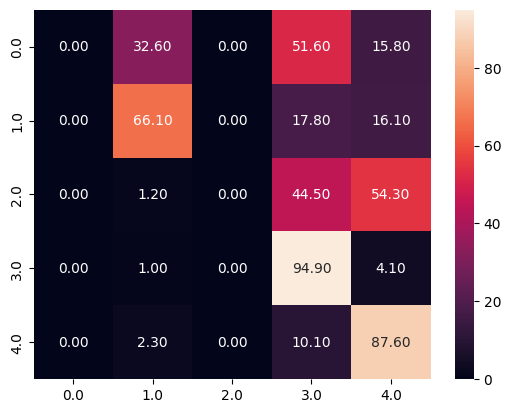

In [122]:
from sklearn.cluster import KMeans
        
kmeans = KMeans(n_clusters=5, random_state=42).fit_predict(DATASET)

cm_print(LABEL, correspondance(kmeans.astype(int), LABEL.astype(int)))

### AgglomerativeClustering

best metric: euclidean, best linkage: ward
Accuracy sur base de test : 49.24%
Matrice de confusion :


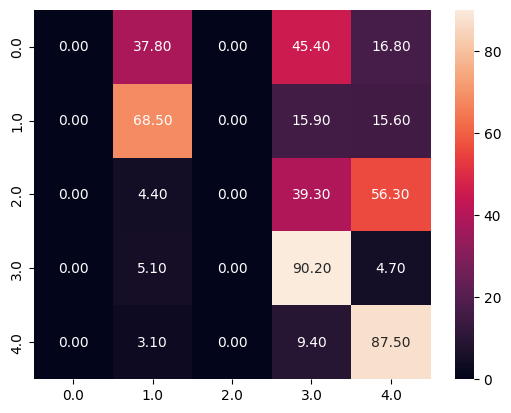

In [123]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

scaler = StandardScaler()
X_scaled = scaler.fit_transform(DATASET)

metrics = ['euclidean', 'manhattan', 'cosine']
linkages = ['ward', 'complete', 'average', 'single']

best_labels, best_accuracy, best_metric, best_linkage = None, 0, None, None
for metric in metrics:
    for linkage in linkages:
        if linkage == 'ward' and metric != 'euclidean':
            continue
        agglo_model = AgglomerativeClustering(
            n_clusters=5,
            metric=metric,
            linkage=linkage # type: ignore
        )
        labels = agglo_model.fit_predict(X_scaled)
        accuracy = accuracy_score(LABEL, correspondance(labels.astype(int), LABEL.astype(int)))
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_labels = labels
            best_metric = metric
            best_linkage = linkage

print(f'best metric: {best_metric}, best linkage: {best_linkage}')
cm_print(LABEL, correspondance(best_labels.astype(int), LABEL.astype(int))) # type: ignore


# Réaliser votre étude :

- Etudier les meilleurs paramètres pour les méthodes supervisées et non supervisées que vous avez choisies.
- Faire une étude sur les paramètres issus de TSFEL en séparant par exemple les différentes modalités (statistiques,temporelles et spectrales) ou en étudiant leur correlation et essayer de réaliser des prétraitements.
- Optimiser la réduction de dimensions par ACP
